In [28]:
!python3 -m pip install git+https://github.com/aireo-project/aireo_lib

  Cloning https://github.com/aireo-project/aireo_lib to /tmp/pip-req-build-42uejisi
  Running command git clone -q https://github.com/aireo-project/aireo_lib /tmp/pip-req-build-42uejisi
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [29]:
import os
os.environ['EXTRA_PATH'] = '/home/jovyan/s3/'

# Introduction

The notebook demonstrates the use of <b> aireo_lib </b>, a python library created as a part of the [AIREO](https://aireo.net/) (Artificial Intelligence Ready Earth Observation training datasets) project. The project aims to make EO datasets easily accessible for the ML (Machine Learning) community. As such, AIREO specifications (shorthand specs) which define metadata elements to be included with the training dataset are proposed, supplemented by a best-practices document which suggests how to fill those metadata elements. Finally, the library takes all into account and implements specs, best-practices and offers an easy-to-use pythonic interface bridging the gap between EO and ML community.

Therefore, this notebook is divided into two sections, one for the training dataset creator (usually from the EO community) and the other for its user (usually from the ML community). The structure of the notebook is the following:


1) For Creator 

    - Create a [STAC](https://stacspec.org/) catalog object using the library
    
    - Populate metadata elements prescribed by the AIREO specs
    
    - Generate a STAC metadata directory using the library

    - Check AIREO compliance level and metadata completeness

   
2) For User 

    - Create a training dataset object as defined in the library using only the STAC metadata
    
    - Get example instances from the object and other dataset variables like the number of instances, etc.
    
    - Use library's functions to plot the data
    
    - Investigate statistics using the library



#### About the training dataset

The CAP (Common Agricultural Policy) dataset, contains crop fields in Austria with different crop types. We have divided all of Austria in rectangular AOIs (Area if Interests) and downloaded Sentinel 2 images at 10 m resolution for each of those, they have been saved as geotiff files. The field shapes and the crop types have been converted to raster masks over these Sentinel 2 images, with each crop denoted by a different number, these are also stored as geotiffs. Only top 10 crop types which occupied almost 85% of the area are used. Hope this information will help you getting started and more can be found in various metadata elements below.

# Dataset Creator

## AIREO STAC Catalog basics


The AIREO specs propose a hierarchical structure for STAC metadata. It is a two level structure where the dataset is represented by a collection of AOIs (Area Of Interests), hence, the dataset and AOI being the two levels.

1. At the dataset level we have a dataset catalog whose metadata elements are the core elements proposed in the AIREO spec. In addition to it, the common metadata elements across each AOI are also at the dataset level, which we shall call root level henceforth. Here, for each data variable there is a separate json which is a STAC Item by definition and is named using the field_schema metadata element. Additionally, there is also a datasheet file in markdown format at the root level which contains human readable information about the key elements of the dataset.

2. Each AOI has a separate folder within the root level. And in each AOI folder there is a STAC collection representing that AOI and additional json files for each data variable. The additional json files here too, are STAC Items and follow a similar naming convention to the ones at the root level. The assets for each AOI, i.e. the files containing actual data are also in the folder.

The diagram below summarises this hierarchical structure:


```
Root level (dataset)
│
│   DatasetCatalog.json
│   datasheet.md
│   references_output1.json
│   features_input1.json
│   ...
│
│
└───AOI 1
│      1.json (AOI Collection)
│      feature_input1.json
│      reference_output1.json
│      <reference_asset>
│      <feature_asseet>
│   
│   
└───AOI 2
│      ...
│   
│
└───AOI 3
│      ...
│   
...     
```

## Creating a STAC catalog with aireo_lib

The aireo_lib library makes it easier to generate the STAC metadata directory as defined above. Some of the useful functionalities in the library are:
-  Define python dictionaries for metadata at the root level and use a simple function to add it to the STAC catalog. The library validates the data automatically when it is added.

- Similarly, python dictionaries can be defined for each AOI and are also validated automatically.

- Links and assets for all the json files are automatically generated.

- Datasheet is also generated automatically.

- The directory structure is created by the library and assets copied to their respective locations in the hierarchy.

- Evaluating metadata completeness and compliance level.


Follow the code and comments below to understand the steps needed to generate STAC metadata with the library.

In [30]:
import aireo_lib.core
import os
import json
import numpy as np
from osgeo import gdal
from tqdm.notebook import tqdm
from shapely import geometry
import shutil
import rioxarray
import xarray as xr
from pathlib import Path


In [31]:
# Creating an empty STAC Catalog object to add metadata to

new_tds_ctl_o = aireo_lib.core.tds_stac_io.DatasetSTACCatalog()


In [51]:
# Creating a list of AOIs in the TDS

reference_path = os.environ['EXTRA_PATH']+'public/CAP/dataset/cap_tiff_mask'
aoi_ids = [int(i.replace('.tif','').replace('patch_mask_','')) for i in os.listdir(reference_path) if '.tif' in i]
print(aoi_ids)

[0, 1, 10, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 11, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 12, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 13, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 14, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 15, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 16, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 17, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 19, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 2, 20, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 23, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 24, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 25, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 26, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 27, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 28, 280, 281, 282,

In [52]:
# A function to get train, validation and test splits of the dataset which can be recorded in the root Catalog
def get_train_val_test_dict():
    patches = [int(i.replace('patch_mask_','').replace('.tif','')) for i in os.listdir(os.environ['EXTRA_PATH']+'public/CAP/dataset/cap_tiff_mask') if 'mask' in i]
    patches.sort()
    # 15% of the AOIs for test and validation split each and the remaning 70% for training
    dim = int(len(patches)*0.15)
    splits = {}
    splits['test_aois'] = patches[:dim]
    splits['val_aois'] = patches[-dim:]
    splits['train_aois'] = patches[dim:-dim]
    return splits

In [53]:
# Creating root Catalog metadata dictionary. These are the CoreElements of AIREO spec.

tds_root_core_metadata_d = {}
tds_root_core_metadata_d['aireo_version'] = "0.0.1-alpha.1"
tds_root_core_metadata_d['title'] = "Fields with crop types from Austria, 2019"
tds_root_core_metadata_d['description'] = "The dataset contains the fields in Austria (as recorded in 2019) with their shapes stored as polygons and the crop type that was grown in the fields. Accompanied with the dataset are satellite images from sentinel 2 with fields as masks over the image. The masks of different crop types have a different number as label."
tds_root_core_metadata_d['created'] = None
tds_root_core_metadata_d['license_url_list'] = ['https://creativecommons.org/licenses/by/4.0/deed.de, https://creativecommons.org/licenses/by-sa/3.0/igo/legalcode']
tds_root_core_metadata_d['license'] = "Various (CC-BY-4.0, Creative Commons CC BY-SA 3.0 IGO)"
tds_root_core_metadata_d["providers_name"]= "[Agricultural Market Austria, Sentinel Hub, AIREO]"
tds_root_core_metadata_d["providers_description"] = "Agricultural Market Austria publsihed the data on field shapes and crop types grown in them. AIREO network downloaded the corresponding satellite imagery for the fields and created masks. AIREO network also created this metadata."
tds_root_core_metadata_d["providers_role"] = {'Sentinel Hub': ["licensor", "producer"], 'AIREO':["producer", "processor" , "host"],'Agricultural Market Austria':["producer", "processor" ]}
tds_root_core_metadata_d["providers_url"]= {'Agricultural Market Austria':'https://www.ama.at/Intro.', 'Sentinel Hub': 'https://www.sentinel-hub.com/', 
                        'AIREO': 'https://aireo.net/'}                         
tds_root_core_metadata_d['id'] =  "970460aa-7835-11eb-9439-0242ac130002"
tds_root_core_metadata_d['type'] = "Collection"
tds_root_core_metadata_d['stac_version'] = '1.0.0-beta.2'
tds_root_core_metadata_d['provenance'] = 'The shapes of fields and the crop type were taken from the data provided by Agricultural Market Austria (see providers) and the accompanying satellite images were provided by Sentinel Hub (see links in providers), as Sentinel 2 images.'
tds_root_core_metadata_d['purpose'] = "The dataset has sentinel 2 images with a mask of fields with 10 different crop types. Each crop type is denoted by a unique identifier. The main prupose for this creating this dataset was to serve as a pilot use case for AIREO specifications. But it can also be used for crop type indentification from satellite images or parcel identification."
tds_root_core_metadata_d['tasks'] =  ['Semantic Segmentation']
tds_root_core_metadata_d['collection_mechanism'] = "The way the underlying data about fields was collected hasn't been mentioned in the source of that data. The satellite images were acquired by optical sensors aboard Sentinel 2 satellite."
tds_root_core_metadata_d['data_preprocessing'] = 'The data was collated using two sources of data: field and crop type from Agricultural Market Austria and Sentinel 2 images from sentinel hub. The process of combining these two datasets by downloading satellite image and overlaying it with a mask of different crop types and fields was done through eo-learn library. \
Only satellite images with cloud cover less than 1% were considered and the dates for the images were chosen to be in late 2019. Also, only the top 10 crop types occupying most area (85% of the total area) were considered from 214 present in the original dataset.'
tds_root_core_metadata_d['funding_info'] = "The AIREO project is funded by ESA, the collection of data on fields and crop types were \
are funded by Agricultural Market Austria and the satellite imagery used is through funds from ESA's Sentinel programme."
tds_root_core_metadata_d['field_schema'] = {'features': {'input1': ['georeferenced_eo_image']}, 'references': {'output1': ['reference_data']}}
tds_root_core_metadata_d['example_definition'] = "An example instance for training a machine learning model would be one satellite image with various bands as predicitve features and the mask as reference data. This can be used for predicting various fields with crop types or for field parcel identification."
tds_root_core_metadata_d['example_window_size'] = 256
tds_root_core_metadata_d['example_stride'] = 26
                                                 
tds_root_core_metadata_d['data_completeness'] = "The data has 10 crop types with fields only from Austria. \
The names of these crops do not follow any standard and are in German and these might not be the only crop types available. There is no information whether these are all the fields in Austria or there are more not included in the dataset. The scenario where multiple crops are grown in a field over the year is also not addressed. There is no unique time for when the crop type for each field was ascertained during 2019."
tds_root_core_metadata_d['data_split'] = f"The  split  should  reflect  a  similar  distribution  of  field  types as in the whole dataset.  It  is  not  necessary  to  match \
distributions of all these 10 crop types but only a few ones occupying most area. \n {get_train_val_test_dict()}"
tds_root_core_metadata_d['data_sharing'] = "The dataset will be shared on Euro Data Cube (EDC) and can be accessed through jupyter notebooks on EDC."
tds_root_core_metadata_d['compliance_level'] = 'level 1'
tds_root_core_metadata_d['links'] =  []


In [54]:
#Common metadata dictionary for predictive feature variable

g_feature_metadata_d = {}
g_feature_metadata_d['type'] = "Feature"
g_feature_metadata_d['stac_version'] = "1.0.0-beta.2"
g_feature_metadata_d['stac_extensions'] = ["georeferenced_eo_image"]
g_feature_metadata_d['id'] = f'common_predictive_feature_metadata'
g_feature_metadata_d['collection'] = "970460aa-7835-11eb-9439-0242ac130002"
with open(os.environ['EXTRA_PATH']+'public/CAP/dataset/austria.geojson','r') as austria:
    shape = json.load(austria)
# The geometry accepts pydantic Geometry type, which is a dictionary. See pydantic's documentation for more info
g_feature_metadata_d['geometry'] = shape['features'][0]['geometry']
geom = np.array(shape['features'][0]['geometry']['coordinates'][0])
xs = geom[:,0]
ys = geom[:,1]
g_feature_metadata_d['bbox'] = [min(xs),min(ys), max(xs), max(ys)]
g_feature_metadata_d['properties'] = {}
g_feature_metadata_d["properties"]['parent_identifier'] = "970460aa-7835-11eb-9439-0242ac130002"
g_feature_metadata_d["properties"]['product_type']  = "Null"
g_feature_metadata_d["properties"]['processing_level'] = 1.0
g_feature_metadata_d["properties"]['platform_short_name'] = "Sentinel 2"
g_feature_metadata_d["properties"]['sensor_type'] = "OPTICAL"
g_feature_metadata_d["properties"]['sensor_resolution'] = "10m"
g_feature_metadata_d["properties"]['gsd'] = 10
g_feature_metadata_d['properties']['datetime'] = "2019"
g_feature_metadata_d['properties']['acquisition_date'] = "2019"
g_feature_metadata_d["properties"]['identifier'] = f'common_predictive_feature_metadata'
g_feature_metadata_d['links'] = []
g_feature_metadata_d["assets"] =  {}
feature_metadata_d = {}
feature_metadata_d['input1'] = g_feature_metadata_d

In [55]:
#Common metadata dictionary for reference data variable

g_ref_data_metadata_d = {}

g_ref_data_metadata_d['id'] = f'common_reference_metadata'
g_ref_data_metadata_d['type'] = "Feature"
g_ref_data_metadata_d['stac_version'] = "1.0.0-beta.2"
g_ref_data_metadata_d['stac_extensions'] = ["reference_data"]
g_ref_data_metadata_d['collection'] = "970460aa-7835-11eb-9439-0242ac130002"
with open(os.environ['EXTRA_PATH']+'public/CAP/dataset/austria.geojson','r') as austria:
    shape = json.load(austria)
# The geometry accepts pydantic Geometry type, which is a dictionary. See pydantic's documentation for more info
g_ref_data_metadata_d['geometry'] = shape['features'][0]['geometry']
geom = np.array(shape['features'][0]['geometry']['coordinates'][0])
xs = geom[:,0]
ys = geom[:,1]
g_ref_data_metadata_d['bbox'] = [min(xs),min(ys), max(xs), max(ys)]
g_ref_data_metadata_d['properties'] = {}
g_ref_data_metadata_d["properties"]['name'] = "Reference metadata"
g_ref_data_metadata_d['properties']['description'] = "The reference data consists of masks of different field types as given in the 2019 dataset by Agricultural Market Austria. Originally, it was  meant for processing of CAP subsidies but can be used for segmentation in the current form."
g_ref_data_metadata_d['properties']['type'] = "Raster"
g_ref_data_metadata_d['properties']['task'] = "Semantic Segmentation"
g_ref_data_metadata_d['properties']['classes'] = [{'ALM FORAGE AREA': 990, 'MOWING MEADOW / PASTURE THREE AND MORE USES': 717,
                   'WINTER SOFT WHEAT': 138, 'MOWING MEADOW / PASTURE TWO USES': 716,
                   'GRAIN CORN': 105, 'WINTER BARLEY': 110, 'SILO CORN': 109, 'PERMANENT PASTURE': 715,
                   'SOYBEANS': 308, 'HAT WILLOW': 707, 'BACKGROUND': 0}]
g_ref_data_metadata_d['properties']['overviews'] = ["They are two overviews total area covered by each field type anda and total number of each field types. Total area covered in hectares ,\
    990: 922491.316277, 717: 495099.341968, 138 : 245556.123391, 716: 212395.276761, 105: 196645.398665, 110: 100947.839432,\
    109: 85574.511958, 715: 77478.090196, 308: 69023.96593, 707: 62440.674009 \
    total number of fields with the crop type, 717: 403540, 716: 315165, 990: 237072, 771: 120610, 351: 120479, 138: 120310, 105: 112095, 707: 110882, 715: 89674,\
    901: 81586"]
g_ref_data_metadata_d['properties']['collection_methods'] = "The reference data was collected by Agricultural Market Austria for the year 2019 for Common Agriculture Practices for EU to process agriculture subsidies, etc. The exact method for ground surveys was not clearly documented and the only info available is that \"all field uses were recorded by the applicants\"."
g_ref_data_metadata_d['properties']['data_preprocessing'] = "The polygons in the original reference data were converted into rasters overlayed on satellite image of 10m resoltuion. \
Only the top 10 crop types occupying most area (85% of total) were used and others were filtered out and labelled as background."
g_ref_data_metadata_d['properties']['CRS'] = 'EPSG:32631'
g_ref_data_metadata_d['properties']['time_range'] = '2019'
g_ref_data_metadata_d["properties"]['value'] = 0
g_ref_data_metadata_d["properties"]['datetime'] = "2019"
g_ref_data_metadata_d['links'] = []
g_ref_data_metadata_d["assets"] = {}

ref_metadata_d = {}
ref_metadata_d['output1'] = g_ref_data_metadata_d

In [56]:
# Add TDS root Catalog and common Item metadata to the catalog object. 
# Note, that it returns True, if the data isn't validated it will return False

new_tds_ctl_o.add_tds_root_metadata(tds_root_core_metadata_d, feature_metadata_d, ref_metadata_d)


True

In [57]:
# Adding metadata for each AOI

for aoi_id in tqdm(aoi_ids[:7]):
        
    # Dictionary for each AOI collection metadata
    aoi_metadata_d = {}
    aoi_metadata_d['type'] = "Collection"
    aoi_metadata_d["id"] = f"{aoi_id}"
    aoi_metadata_d['stac_version'] = '1.0.0-beta.2'
    aoi_metadata_d['title'] = f"{aoi_id} Collection"
    aoi_metadata_d['description'] = "Each AOI contains satellite images with crop masks."
    aoi_metadata_d["license"] = "Various (CC-BY-4.0, Creative Commons CC BY-SA 3.0 IGO)"
    mask = gdal.Open(os.path.join(reference_path, f'patch_mask_{aoi_id}.tif'))
    geoTransform = mask.GetGeoTransform()
    minx = geoTransform[0]
    maxy = geoTransform[3]
    maxx = minx + geoTransform[1] * mask.RasterXSize
    miny = maxy + geoTransform[5] * mask.RasterYSize
    aoi_metadata_d["bbox"]= [minx, miny, maxx, maxy]
    # The geometry accepts pydantic Geometry type, which is a dictionary. See pydantic's documentation for more info
    aoi_metadata_d['geometry'] = geometry.mapping(geometry.box(*aoi_metadata_d["bbox"]))
    aoi_metadata_d["extent"] = {"spatial" : {"bbox":[[minx, miny, maxx, maxy]]}, 
                      "temporal": {"interval":[['2019']]}}
    aoi_metadata_d['time_range'] = '2019'
    aoi_metadata_d['links'] = []
    aoi_metadata_d["assets"] = {}
    
    
    # Dictionary for each AOI's predictive feature variable metadata
    aoi_feature_metadata_d = {}
    aoi_feature_metadata_d['id'] = f'predictive_feature_metadata_AOI_{aoi_id}'
    aoi_feature_metadata_d['type'] = "Feature"
    aoi_feature_metadata_d['stac_version'] = "1.0.0-beta.2"
    aoi_feature_metadata_d['stac_extensions'] = ["georeferenced_eo_image"]
    aoi_feature_metadata_d['collection'] = "970460aa-7835-11eb-9439-0242ac130002"
    aoi_feature_metadata_d['bbox'] = aoi_metadata_d["bbox"]
    aoi_feature_metadata_d['geometry'] = aoi_metadata_d["geometry"]
    aoi_feature_metadata_d['properties'] = {}
    aoi_feature_metadata_d["properties"]['parent_identifier'] = "970460aa-7835-11eb-9439-0242ac130002"
    aoi_feature_metadata_d["properties"]['product_type']  = "Null"
    aoi_feature_metadata_d["properties"]['processing_level'] = 1.0
    aoi_feature_metadata_d["properties"]['platform_short_name'] = "Sentinel 2"
    aoi_feature_metadata_d["properties"]['sensor_type'] = "OPTICAL"
    aoi_feature_metadata_d["properties"]['sensor_resolution'] = "10m"
    aoi_feature_metadata_d["properties"]['gsd'] = 10
    aoi_feature_metadata_d["properties"]['CRS'] = 'EPSG:32631'
    aoi_feature_metadata_d["properties"]['identifier'] = str(aoi_id)
    aoi_feature_metadata_d["properties"]['acquisition_date'] = '2019'
    aoi_feature_metadata_d["properties"]['datetime'] = "2020-03-09T14:53:23.262208+00:00"
    aoi_feature_metadata_d['links'] = []  
    aoi_feature_metadata_d["assets"] = {}

    aoi_feature_d = {}
    aoi_feature_d['input1'] = aoi_feature_metadata_d
    
    # Dictionary for each AOI's reference variable metadata
    aoi_ref_data_metadata_d = {}
    aoi_ref_data_metadata_d['type'] = "Feature"
    aoi_ref_data_metadata_d['stac_version'] = "1.0.0-beta.2"
    aoi_ref_data_metadata_d['stac_extensions'] = ["reference_data"]
    aoi_ref_data_metadata_d['id'] = f'reference_metadata_AOI_{aoi_id}'
    aoi_ref_data_metadata_d['collection'] = "970460aa-7835-11eb-9439-0242ac130002"
    aoi_ref_data_metadata_d["bbox"]= aoi_metadata_d["bbox"]
    aoi_ref_data_metadata_d['geometry'] = aoi_metadata_d["geometry"]
    aoi_ref_data_metadata_d["properties"] = {}
    aoi_ref_data_metadata_d['properties']['classes'] = [{'ALM FORAGE AREA': 990, 'MOWING MEADOW / PASTURE THREE AND MORE USES': 717,
                       'WINTER SOFT WHEAT': 138, 'MOWING MEADOW / PASTURE TWO USES': 716,
                       'GRAIN CORN': 105, 'WINTER BARLEY': 110, 'SILO CORN': 109, 'PERMANENT PASTURE': 715,
                       'SOYBEANS': 308, 'HAT WILLOW': 707, 'BACKGROUND': 0}]
    aoi_ref_data_metadata_d["properties"]['name'] = str(aoi_id)+ " Reference metadata"
    aoi_ref_data_metadata_d['properties']['description'] = "The reference data consists of masks of different field types as given in the 2019 dataset by Agricultural Market Austria. Originally, it was  meant for processing of CAP subsidies but can be used for segmentation in the current form."
    aoi_ref_data_metadata_d['properties']['type'] = "Raster"
    aoi_ref_data_metadata_d['properties']['task'] = "Semantic Segmentation"
    aoi_ref_data_metadata_d['properties']['CRS'] = 'EPSG:32631'
    aoi_ref_data_metadata_d['properties']['time_range'] = '2019'
    aoi_ref_data_metadata_d["properties"]['value'] = 0
    aoi_ref_data_metadata_d['properties']["orientation"]= "null"
    aoi_ref_data_metadata_d["properties"]['datetime'] = "2019"
    aoi_ref_data_metadata_d['links'] = []
    aoi_ref_data_metadata_d["assets"] = {}
    aoi_ref_d = {}
    aoi_ref_d['output1'] = aoi_ref_data_metadata_d
    
    # Defining path to assets to copy over to AOI directory
    aoi_ref_data_asset_path_d = {'output1':os.path.join(os.environ['EXTRA_PATH']+'public/CAP/dataset/cap_tiff_mask', f'patch_mask_{aoi_id}.tif')}
    aoi_feature_asset_path_d = {'input1':os.path.join(os.environ['EXTRA_PATH']+'public/CAP/dataset/cap_tiff', f'patch_{aoi_id}.tif')}
    
    # Add each AOI's metadata to catalog object. Note, each AOI is also validated and returns True.
    print(new_tds_ctl_o.add_aoi_metadata(aoi_metadata_d=aoi_metadata_d,
                                   aoi_feature_metadata_d=aoi_feature_d,
                                   aoi_ref_data_metadata_d=aoi_ref_d,
                                   aoi_feature_asset_path_d=aoi_feature_asset_path_d,
                                   aoi_ref_data_asset_path_d=aoi_ref_data_asset_path_d))


  0%|          | 0/7 [00:00<?, ?it/s]

True
True
True
True
True
True
True


In [60]:
import shutil
shutil.rmtree(os.environ['EXTRA_PATH']+'public/CAP/cap_stac_generated')

In [61]:
# Writing the STAC metadata. The directory along with its structure is generated, with correct links and assets defined. 
#A datasheet is also generated

catalog_fn_w_path = os.environ['EXTRA_PATH']+'public/CAP/cap_stac_generated/TDS.json'
new_tds_ctl_o.write_TDS_STAC_Catalog(catalog_fn_w_path)


#### Checking AIREO compliance level

In [62]:
# Checks the compliance level of the metadata as defined in AIREO spec.

catalog_fn_w_path = os.environ['EXTRA_PATH']+'public/CAP/cap_stac_generated/TDS.json'
new_tds_ctl_o = aireo_lib.core.tds_stac_io.DatasetSTACCatalog.from_TDSCatalog(catalog_fn_w_path)
new_tds_ctl_o.compute_compliance_level()

1

#### Checking metadata completeness

In [63]:
new_tds_ctl_o.report_metadata_completeness()

{'tds_core_metadata': {'required_metadata': 1.0,
  'recommended_metadata': 0.4166666666666667,
  'optional_metadata': 0.29411764705882354}}

### Defining AOI class

For enabling many other functionalities of the library the dataset creator needs to create an AOI class which defines how the asset files are loaded, can return an example and length of the dataset. The blueprint is given in the library by the AOIDataset class which this class should inherit. In the future, it is planned to automate the creation of the AOI class also.

In [64]:
#should inherit AOIDataset

from aireo_lib.core import AOIDataset

class AOIDatasetCAP(AOIDataset):

    def __init__(self, AOI_STAC_collection, TDS_STAC_catalog):

        self.AOI_STAC_collection = AOI_STAC_collection
        self.TDS_STAC_catalog = TDS_STAC_catalog
        self.stride = self.TDS_STAC_catalog.tds_ctl_root_info.tds_root_metadata_d['example_stride']
        self.window_size = self.TDS_STAC_catalog.tds_ctl_root_info.tds_root_metadata_d['example_window_size']
        

        _first = True
        
        for eo_feature in self.AOI_STAC_collection.aoi_all_field_metadata.features:
            aoi_feature_asset_path_d = self.AOI_STAC_collection.aoi_all_field_metadata.features[eo_feature].data_asset_w_path
            self.feature_var_name = 'features_'+eo_feature
            if _first:
                self.data = rioxarray.open_rasterio(aoi_feature_asset_path_d).to_dataset(name=self.feature_var_name) 
                _first = False
            else:
                tmp = rioxarray.open_rasterio(aoi_feature_asset_path_d)
                self.data[self.feature_var_name] = tmp
                self.data[self.feature_var_name].values = tmp.values
                
        aoi_name = aoi_feature_asset_path_d.split('/')[-1].replace('patch_','').replace('.tif','')
        for reference_data in self.AOI_STAC_collection.aoi_all_field_metadata.references:
            aoi_ref_data_asset_path_d = self.AOI_STAC_collection.aoi_all_field_metadata.references[reference_data].data_asset_w_path
            self.ref_var_name = 'references_'+reference_data
            if _first:
                self.data = rioxarray.open_rasterio(aoi_ref_data_asset_path_d).to_dataset(name = self.ref_var_name)
                _first = False
            else:
                tmp = rioxarray.open_rasterio(aoi_ref_data_asset_path_d).rename({'band':'mask'})
                self.data[self.ref_var_name] = tmp
                self.data[self.ref_var_name].values = tmp.values
                self.data.attrs = tmp.attrs


    def __getitem__(self, index):
       
        along_x = int((self.data[self.feature_var_name].shape[1] - self.window_size)/self.stride)
        along_y = int((self.data[self.feature_var_name].shape[-1] - self.window_size)/self.stride)
        x1 = self.stride * int(index % along_x)
        y1 = self.stride * int(index / along_y)
        x2 = x1 + self.window_size
        y2 = y1 + self.window_size
        
        #store feature and reference data in same xarray, name the axes
        ds = self.data.isel(band=[0,1,2,3], mask=[0], x=slice(x1,x2), y=slice(y1, y2))        
        return ds
    

    def __len__(self):
        
        along_x = int((self.data[self.feature_var_name].shape[1] - self.window_size)/self.stride) + 1
        along_y = int((self.data[self.feature_var_name].shape[-1] - self.window_size)/self.stride) + 1
        return along_x * along_y
    
    def get_length(self):
        return self.__len__()

## Dataset user

The user of the dataset can access most of what is offered by the dataset using just its STAC catalog. All he/she needs to do is create a dataset object by passing to it the path to the STAC catalog at the root level. The library automatically reads in all the metadata and loads the assets into the dataset object. Some of the functionalities that a dataset object offers through aireo_lib are:

- Can access an example instance from the dataset which serves as an input-output pair for a Machine Learning algorithm.

- Xarrays are used to store data and give examples.

- Dataset can also return each AOI independently

- Offer basic plotting functions for each variable in the dataset and AOI.

- Some statistics can also be calculated at both the AOI level and whole dataset level.


### Parsing the dataset by creating a dataset object

In [65]:
from aireo_lib.core import EOTrainingDataset

cap_tds_ctl_fn = Path(os.environ['EXTRA_PATH']+'public/CAP/cap_stac_generated/TDS.json')

eo_tds_obj = EOTrainingDataset(cap_tds_ctl_fn, AOIDatasetCAP)


In [66]:
# Getting the number of instances/examples in the dataset

len(eo_tds_obj)


5887

In [67]:
# Accessing an example through index

eo_tds_obj[-5]

<xarray.Dataset>
Dimensions:             (band: 4, mask: 1, x: 256, y: 239)
Coordinates:
  * x                   (x) float64 1.119e+06 1.119e+06 ... 1.122e+06 1.122e+06
  * y                   (y) float64 5.263e+06 5.263e+06 ... 5.261e+06 5.261e+06
  * band                (band) int64 1 2 3 4
    spatial_ref         int64 0
  * mask                (mask) int64 1
Data variables:
    features_input1     (band, y, x) float32 ...
    references_output1  (mask, y, x) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [68]:
# Accessing one variable of the instance

eo_tds_obj[-5]['references_output1'].values


array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0, 707, 707, ...,   0,   0,   0],
        [  0, 707, 707, ...,   0,   0,   0],
        [  0, 707, 707, ...,   0,   0,   0]]], dtype=int32)

In [69]:
# Get a subset of examples

eo_tds_obj.get_subset([19,1121, 2000, 2345])

[<xarray.Dataset>
 Dimensions:             (band: 4, mask: 1, x: 256, y: 256)
 Coordinates:
   * x                   (x) float64 9.976e+05 9.976e+05 ... 1e+06 1e+06
   * y                   (y) float64 5.241e+06 5.241e+06 ... 5.238e+06 5.238e+06
   * band                (band) int64 1 2 3 4
     spatial_ref         int64 0
   * mask                (mask) int64 1
 Data variables:
     features_input1     (band, y, x) float32 ...
     references_output1  (mask, y, x) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
 Attributes:
     _FillValue:    0.0
     scale_factor:  1.0
     add_offset:    0.0,
 <xarray.Dataset>
 Dimensions:             (band: 4, mask: 1, x: 256, y: 256)
 Coordinates:
   * x                   (x) float64 9.927e+05 9.927e+05 ... 9.952e+05 9.952e+05
   * y                   (y) float64 5.248e+06 5.248e+06 ... 5.246e+06 5.246e+06
   * band                (band) int64 1 2 3 4
     spatial_ref         int64 0
   * mask                (mask) int64 1
 Data variables:
     featu

In [70]:
# Access each AOI independently

aoi_objs = eo_tds_obj.get_aoi_datasets()
len(aoi_objs[1])

841

### Plotting functions in aireo_lib

In [71]:
from aireo_lib.plotting import EOTDSPlot as aireo_viz


In [72]:
# Basic plot of all the variables in the dataset, returns a dict of matplotlib figures

plot_d = aireo_viz.plot_example(EOTDS=eo_tds_obj, 
                       ex_index=-50, 
                       field_names=['features_input1', 'references_output1'])
plot_d


{'features_input1': <Figure size 640x480 with 1 Axes>,
 'references_output1': <Figure size 640x480 with 2 Axes>}

In [73]:
%matplotlib inline

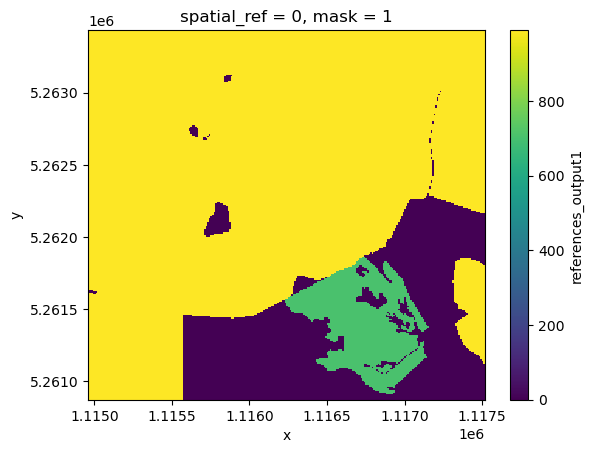

In [74]:
plot_d['references_output1']

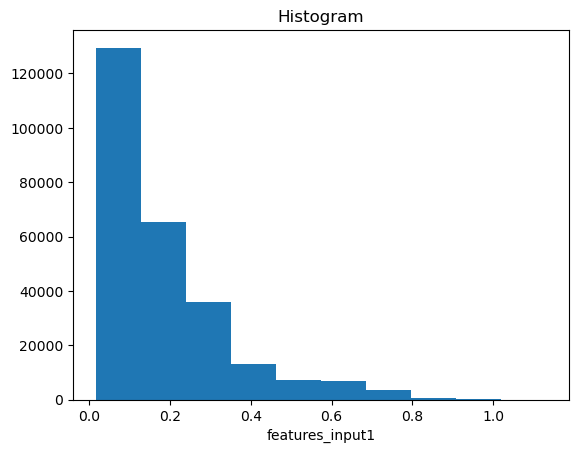

In [75]:
plot_d['features_input1']


In [76]:
aoi_obj = eo_tds_obj.get_aoi_dataset(2)

{'features_input1': <Figure size 432x288 with 1 Axes>,
 'references_output1': <Figure size 432x288 with 2 Axes>}

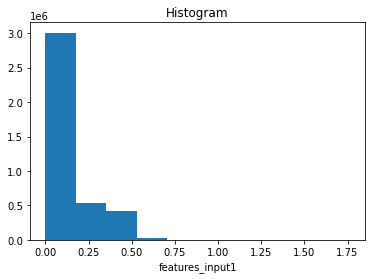

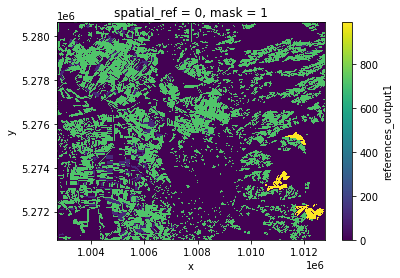

In [77]:
# Basic plot of all the variables in an AOI, returns a dict of matplotlib figures

aoi_plots_d = aireo_viz.plot_aoi_dataset(aoi_obj)
aoi_plots_d

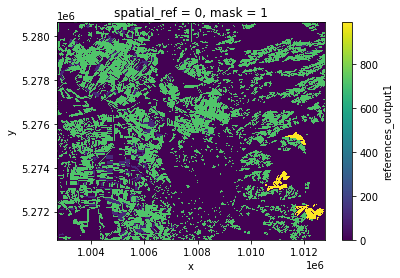

In [78]:
aoi_plots_d['references_output1']

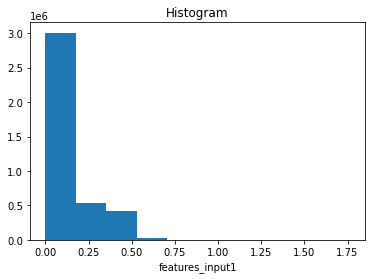

In [79]:
aoi_plots_d['features_input1']

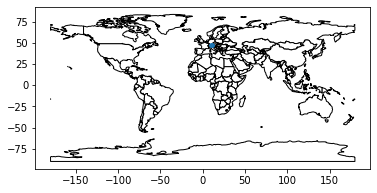

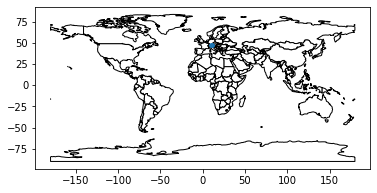

In [80]:
# Plotting different AOIs on the map of the world

aireo_viz.map_aois(eo_tds_obj)

### Statistics functions in aireo_lib


In [86]:
from aireo_lib.statistics import EOTDSStatistics as stats


In [87]:
# Common reference data statistics llike number of samples of each class in the whole dataset and each AOI

stats.reference_data_statistics(eo_tds_obj)

{'references_output1_aoi0': Counter({0: 985158, 990: 11814}),
 'references_output1_aoi1': Counter({0: 944886,
          717: 11806,
          109: 343,
          716: 5701,
          715: 496,
          707: 504,
          990: 33236}),
 'references_output1_aoi2': Counter({716: 35759,
          0: 652113,
          717: 269126,
          715: 6357,
          109: 23530,
          707: 1806,
          105: 304,
          110: 105,
          990: 7872}),
 'references_output1_aoi3': Counter({990: 346017,
          0: 650301,
          716: 287,
          707: 367}),
 'references_output1_aoi4': Counter({990: 424944,
          0: 569379,
          707: 2326,
          716: 323}),
 'references_output1_aoi5': Counter({990: 642174,
          0: 325099,
          707: 11756,
          716: 17353,
          715: 241,
          717: 349}),
 'references_output1_aoi6': Counter({717: 73514,
          0: 597380,
          109: 13172,
          716: 33760,
          990: 257307,
          110: 747,
  

In [88]:
# Common feature data statistics like mean, standard deviation, min and max for each channel in each AOI

stats.feature_data_statistics(eo_tds_obj)

{'aoi_0_channel_0': {'mean': 0.2188684046268463,
  'std': 0.29485493898391724,
  'max': 1.7632,
  'min': 1e-04},
 'aoi_0_channel_1': {'mean': 0.2414350062608719,
  'std': 0.28957974910736084,
  'max': 1.6784,
  'min': 1e-04},
 'aoi_0_channel_2': {'mean': 0.23368050158023834,
  'std': 0.29505816102027893,
  'max': 1.62,
  'min': 1e-04},
 'aoi_0_channel_3': {'mean': 0.38848695158958435,
  'std': 0.18614201247692108,
  'max': 1.5498,
  'min': 0.0091},
 'aoi_1_channel_0': {'mean': 0.07517736405134201,
  'std': 0.11914647370576859,
  'max': 1.768,
  'min': 1e-04},
 'aoi_1_channel_1': {'mean': 0.09842635691165924,
  'std': 0.11607716232538223,
  'max': 1.68,
  'min': 1e-04},
 'aoi_1_channel_2': {'mean': 0.08524385839700699,
  'std': 0.12253619730472565,
  'max': 1.6232,
  'min': 1e-04},
 'aoi_1_channel_3': {'mean': 0.3145008385181427,
  'std': 0.12078604847192764,
  'max': 1.5504,
  'min': 0.0129},
 'aoi_2_channel_0': {'mean': 0.048552945256233215,
  'std': 0.03687962889671326,
  'max': 1.76

In [89]:
stats.dataset_statistics(eo_tds_obj)

{'num_examples': 5887,
 'references_stats': {'references_output1_aoi0': Counter({0: 985158,
           990: 11814}),
  'references_output1_aoi1': Counter({0: 944886,
           717: 11806,
           109: 343,
           716: 5701,
           715: 496,
           707: 504,
           990: 33236}),
  'references_output1_aoi2': Counter({716: 35759,
           0: 652113,
           717: 269126,
           715: 6357,
           109: 23530,
           707: 1806,
           105: 304,
           110: 105,
           990: 7872}),
  'references_output1_aoi3': Counter({990: 346017,
           0: 650301,
           716: 287,
           707: 367}),
  'references_output1_aoi4': Counter({990: 424944,
           0: 569379,
           707: 2326,
           716: 323}),
  'references_output1_aoi5': Counter({990: 642174,
           0: 325099,
           707: 11756,
           716: 17353,
           715: 241,
           717: 349}),
  'references_output1_aoi6': Counter({717: 73514,
           0: 597380,
  

In [90]:
# Metadata completeness statistics also included

stats.metadata_statistics(eo_tds_obj)

{'tds_core_metadata': {'required_metadata': 1.0,
  'recommended_metadata': 0.4166666666666667,
  'optional_metadata': 0.29411764705882354}}

## ML model


We try to demonstrate here how the library interfaces with existing ML libraries. This is an over simplistic implementation of resnet50 from pytorch to show this functionality of our library. We train the model for a few epochs with a few instances from our dataset object. The choices made here like loss function, optimizer, training indexes, etc. are only meant for demonstration and are in no way recommended and do not claim to be sensible choices.


In [91]:
import torchvision
import torch

In [92]:
# Creating the model object from torchvision

model = torchvision.models.segmentation.fcn_resnet50(pretrained=False, progress=True, num_classes=11)

In [93]:
# Defining a loss function and optimizer

def loss_fn(pred, truth):
    pred = np.amax(pred.detach().numpy(),1)
    return torch.tensor(sum(abs(pred-truth).flatten()), requires_grad=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [94]:
# Generating a few training instances from the dataset object

import random
train_indexes = random.choices(list(range(0, len(eo_tds_obj))),k=10)
train_indexes

[1803, 1138, 814, 2375, 2595, 3855, 2080, 3038, 1404, 1746]

In [95]:
# Training the model for a few epochs

model.train()
for epoch in range(4):
    print(f"Epoch {epoch}")
    total_loss = 0
    for train_idx in train_indexes:
        optimizer.zero_grad()
        
        # Getting one training instance from the dataset object
        instance = eo_tds_obj[train_idx]
        
        # As resnet50 accepts only 3-D inputs we use only the first three bands of our satellite image
        train_input = torch.tensor(np.expand_dims(instance.features_input1.values[:3,:,:], axis=0))
        
        # Reference data becomes label for training
        train_labels = instance.references_output1.values
        
        output = model.forward(train_input)
        loss = loss_fn(output['out'], train_labels)
        
        loss.backward()
        optimizer.step()
        total_loss += loss
    print('Total Running Loss:', loss.item())

Epoch 0
Total Running Loss: 20628980.817739315
Epoch 1
Total Running Loss: 20629300.919117928
Epoch 2
Total Running Loss: 20629116.251183357
Epoch 3
Total Running Loss: 20629180.92278721
